## Import et prétraitement

Import des libraries et méthodes

In [40]:
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
# from pathlib import Path
tf.__version__
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Import des dataset

In [41]:
! git clone https://github.com/kumquat42/ProjetFinal_JedhaDS27_Emotions.git

fatal: destination path 'ProjetFinal_JedhaDS27_Emotions' already exists and is not an empty directory.


In [42]:
train_dir = "/content/ProjetFinal_JedhaDS27_Emotions/Datasets/FER2013/train"
test_dir = "/content/ProjetFinal_JedhaDS27_Emotions/Datasets/FER2013/test"

Affichons une image

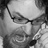

In [43]:
with Image.open(f'{test_dir}/angry/PrivateTest_10131363.jpg') as img:
#with Image.open(f'{train_dir}/angry/Training_10118481.jpg') as img:
  display(img)

In [44]:
BATCH_SIZE = 64

EARLY_STOPPING_CRITERIA = 10 # Permet d'arrêter le modèle lorsqu'il tourne dans le vide
EPOCHS = 200


#  Class labels : 0,, 1, 2, 3, 4, 5, 6. cf. surprise =6 [0. 0. 0. 0. 0. 0. 1.]
CLASS_LABELS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

class_weight = {0: 28709/3995/2.0,
                1: 28709/436/2.0,
                2: 28709/4097/2.0,
                3: 28709/7215/2.0,
                4: 28709/4965/2.0,
                5: 28709/4830/2.0,
                6: 28709/3171/2.0}

In [45]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.3
)

train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle=True,
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle=True,
    subset="validation"
)

Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.


In [ ]:
from pathlib import Path

# voir les images - à tester...
imgs, labels = next(iter(train_generator))
for img, label in zip(imgs, labels):
  true_file_path = np.argmax(train_generator.labels == tf.argmax(label)) # Je cherche n'importe quelle index avec une valeur True
  true_label_name = Path(train_generator.filepaths[true_file_path]).parent.name
  print(label)
  plt.imshow(img)
  plt.title(true_label_name)
  plt.show()

### Modèle

On crée une structure.

In [62]:
input = Input(shape = (48,48,1))
conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2))(conv1)
conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2))(conv3)
conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2))(conv4)
flatten = Flatten()(pool4)
dense_1 = Dense(128,activation='relu')(flatten)
drop_1 = Dropout(0.2)(dense_1)
output = Dense(7,activation="sigmoid")(drop_1)

On crée notre modèle.

In [63]:
model = Model(inputs=input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 dropout_25 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 activation_20 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 64)        18496     
                                                           

## Entrainement du modèle

In [64]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1,
                                                         restore_best_weights=True
)

history = model.fit(train_generator,
                    epochs = EPOCHS,
                    validation_data = validation_generator,
                    callbacks=[earlyStoppingCallback],
                    class_weight=class_weight)

Epoch 1/200
315/315 [==============================] - 15s 41ms/step - loss: 6.8700 - categorical_accuracy: 0.1582 - val_loss: 1.9350 - val_categorical_accuracy: 0.1880
Epoch 2/200
315/315 [==============================] - 13s 41ms/step - loss: 6.7054 - categorical_accuracy: 0.2003 - val_loss: 1.8939 - val_categorical_accuracy: 0.2611
Epoch 3/200
315/315 [==============================] - 13s 42ms/step - loss: 6.3689 - categorical_accuracy: 0.2680 - val_loss: 1.8573 - val_categorical_accuracy: 0.2656
Epoch 4/200
315/315 [==============================] - 14s 44ms/step - loss: 6.0196 - categorical_accuracy: 0.3271 - val_loss: 1.7857 - val_categorical_accuracy: 0.3369
Epoch 5/200
315/315 [==============================] - 16s 51ms/step - loss: 5.6537 - categorical_accuracy: 0.3760 - val_loss: 1.6243 - val_categorical_accuracy: 0.4236
Epoch 6/200
315/315 [==============================] - 14s 45ms/step - loss: 5.3832 - categorical_accuracy: 0.4034 - val_loss: 1.6309 - val_categorical_acc

Affichage des courbes de perte de d'accuracy en fonction des epochs

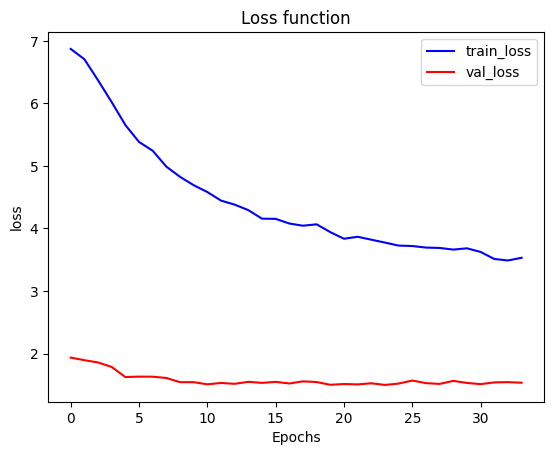

In [65]:
plt.plot(history.history["loss"], color="b", label="train_loss")
plt.plot(history.history["val_loss"], color="r", label="val_loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title("Loss function")
plt.legend()
plt.show()

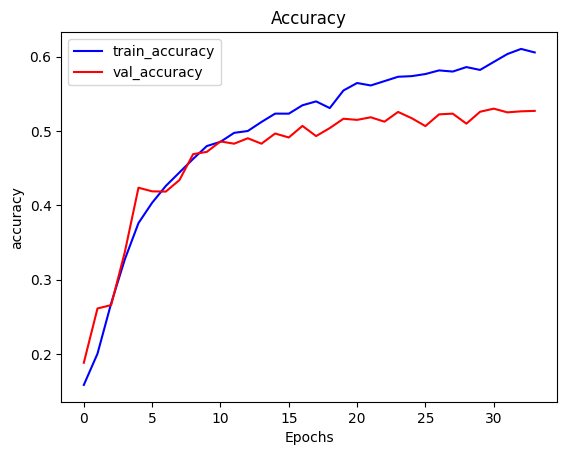

In [66]:
plt.plot(history.history["categorical_accuracy"], color="b", label="train_accuracy")
plt.plot(history.history["val_categorical_accuracy"], color="r", label="val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy")
plt.legend()
plt.show()

On prepare le jeu de test et on fait nos predictions.

In [67]:
test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    shuffle=True
)

Found 7178 images belonging to 7 classes.


In [68]:
predictions_probas = model.predict(test_generator)
predictions = np.argmax(predictions_probas, axis=1)
results = pd.DataFrame({"test" : test_generator.classes, "pred" : predictions})
results["pred"] = round(results["pred"])
print(classification_report(results["test"], results["pred"]))

113/113 [==============================] - 4s 35ms/step
              precision    recall  f1-score   support

           0       0.14      0.13      0.13       958
           1       0.03      0.05      0.04       111
           2       0.12      0.06      0.08      1024
           3       0.25      0.26      0.25      1774
           4       0.16      0.20      0.18      1233
           5       0.17      0.19      0.18      1247
           6       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



Affichons la matrice de confusion.

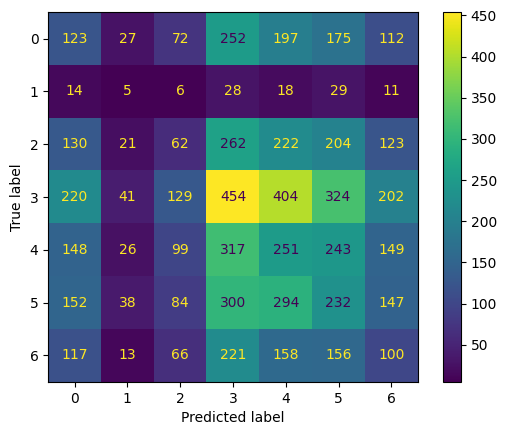

In [69]:
cm = confusion_matrix(results["test"], results["pred"])
ConfusionMatrixDisplay(cm).plot()
plt.show()

Sauvegardons le modèle, les scores et les predictions.

In [70]:
history_df = pd.DataFrame(history.history)

In [71]:
model.save("/content/ProjetFinal_JedhaDS27_Emotions/Modèles/modele_theo/model_theo.h5")
history_df.to_csv("/content/ProjetFinal_JedhaDS27_Emotions/Modèles/modele_theo/history_theo.csv")
results.to_csv("/content/ProjetFinal_JedhaDS27_Emotions/Modèles/modele_theo/predictions_theo.csv")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Téléchargement du dossier modele_theo sur le PC local

In [73]:
!zip -r /content/ProjetFinal_JedhaDS27_Emotions/Modèles/modele_theo.zip /content/ProjetFinal_JedhaDS27_Emotions/Modèles/modele_theo

  adding: content/ProjetFinal_JedhaDS27_Emotions/Modèles/modele_theo/ (stored 0%)
  adding: content/ProjetFinal_JedhaDS27_Emotions/Modèles/modele_theo/model_theo.h5 (deflated 34%)
  adding: content/ProjetFinal_JedhaDS27_Emotions/Modèles/modele_theo/history_theo.csv (deflated 50%)
  adding: content/ProjetFinal_JedhaDS27_Emotions/Modèles/modele_theo/predictions_theo.csv (deflated 73%)


In [74]:
from google.colab import files

files.download('/content/ProjetFinal_JedhaDS27_Emotions/Modèles/modele_theo.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>